In [ ]:
# The purpose of this notebook is to make noise patches from different sized FOVS and measure their changing NPS

In [1]:
from pathlib import Path
import numpy as np
import seaborn as sns

import sys
sys.path.append('..')

sns.set_theme()
sns.set_style('white')

from nps_utils import compute_nps, radial_profile


In [2]:
from make_noise_patches import prep_patches


datadir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CCT189_peds/CCT189_peds_fbp/')
noise_patch_dict = prep_patches(datadir)

8


In [5]:
dose=100
from make_noise_patches import load_mhd
sa_file_dict={d.stem : next(d.rglob(f'dose_{dose:03d}/*/signal_absent.mhd')) for d in datadir.glob('diameter*mm')}

In [6]:
sa = load_mhd(sa_file_dict['diameter292mm'])
sa.shape

sa_image_dict = {k: load_mhd(v)-1000 for k, v in sa_file_dict.items()}

Text(0.5, 1.0, '[112, 151, 292] mm')

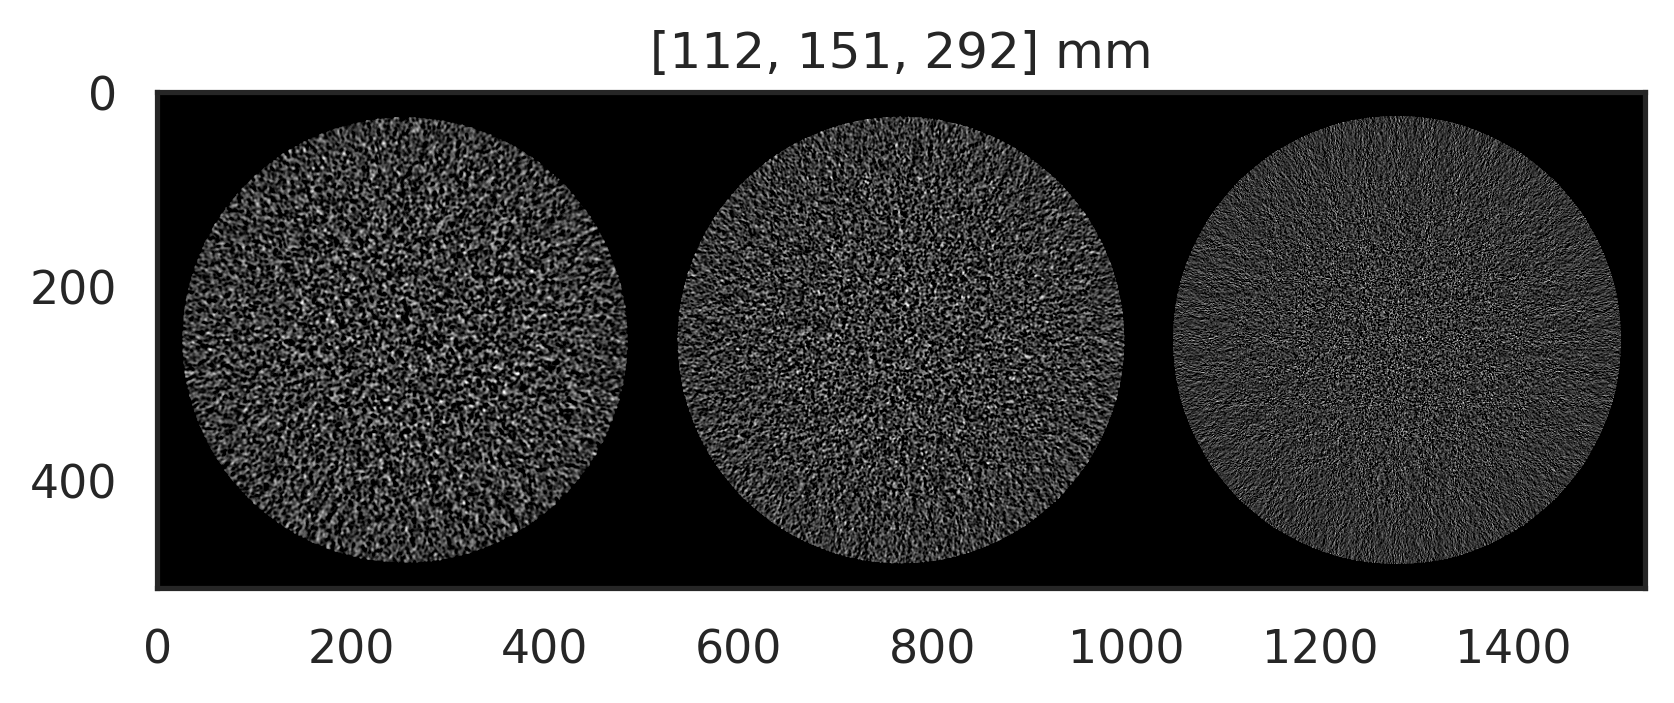

In [7]:
import matplotlib.pyplot as plt
diams = [112, 151, 292]
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate([sa_image_dict[f'diameter{x}mm'][0] for x in diams], axis=1),cmap='gray', vmin=-20, vmax=80)
plt.title(f'{diams} mm')

In [8]:
import numpy as np

from make_noise_patches import make_noise_images


make_noise_images(sa_image_dict['diameter112mm']).shape

(2000, 512, 512)

In [9]:
noise_image_dict = {k: make_noise_images(v, 2000) for k, v in sa_image_dict.items()}

Text(0.5, 1.0, '[112, 151, 292] mm whole noise images')

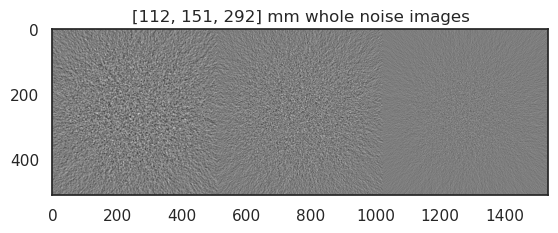

In [10]:
diams = [112, 151, 292]
plt.imshow(np.concatenate([noise_image_dict[f'diameter{x}mm'][0] for x in diams], axis=1), cmap='gray')
plt.title(f'{diams} mm whole noise images')

In [42]:
diams = [112, 151, 292, 350]
nps_images = [compute_nps(noise_image_dict[f'diameter{x}mm']) for x in diams]

Text(0.5, 1.0, '[112, 151, 292, 350] mm whole noise image nps')

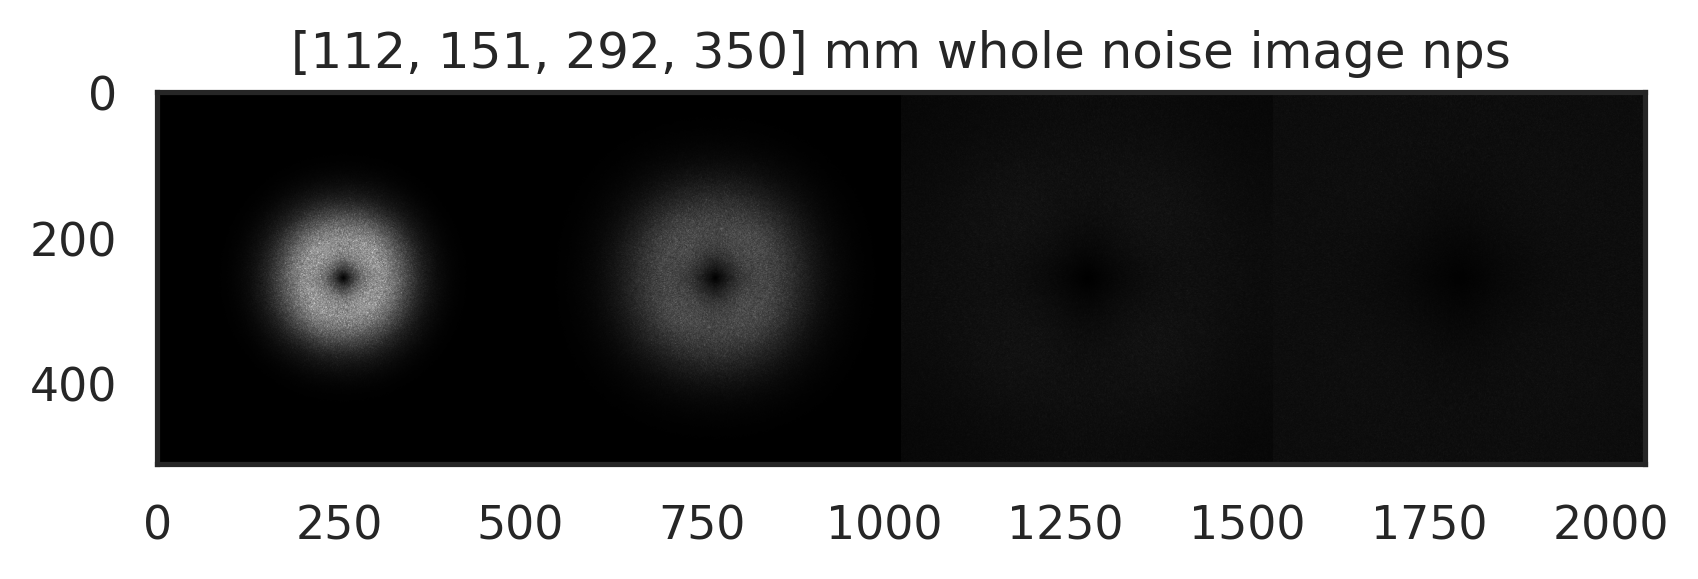

In [43]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate(nps_images, axis=1), cmap='gray')
plt.title(f'{diams} mm whole noise image nps')

 noise texture changes radially and azimuthally

 look at image patches from different regions in the image

[]

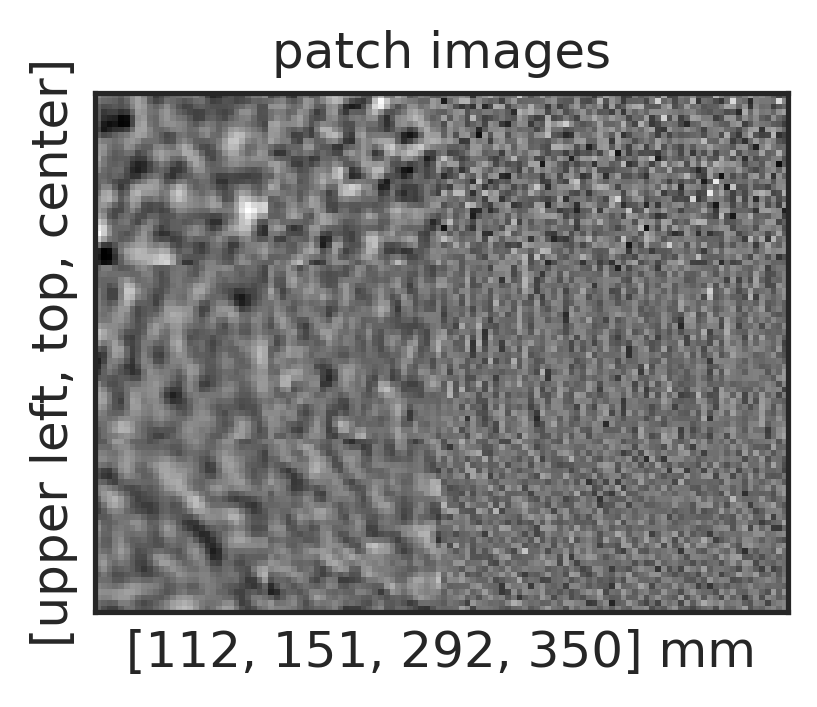

In [75]:
from make_noise_patches import make_noise_image_dict

def get_square_patch(img, center, patch_width=30):
    if img.ndim == 2: img = img[None, :, :]
    return img[:, center[0]-patch_width//2:center[0]+patch_width//2, center[1]-patch_width//2:center[1]+patch_width//2]

def get_patches(img, centers, patch_size=30):
    return {center: get_square_patch(img, center, patch_width=patch_size) for center in centers}


centers = [(256, 256), (50, 256), (110, 110)]
noise_image_dict = make_noise_image_dict(datadir)
corner_patches = [get_patches(noise_image_dict[f'diameter{x}mm'], centers=centers) for x in diams]

corners= list(corner_patches[0].keys())
f, axs = plt.subplots(1,1, dpi=300, figsize=(3,2.25))
region_patches = np.concatenate([np.concatenate([p[c][0] for p in corner_patches], axis=1) for c in corners])
axs.imshow(region_patches, cmap='gray')
axs.set_title('patch images')
axs.set_xlabel(f'{diams} mm')
axs.set_ylabel(f'[upper left, top, center]')
axs.set_xticks([])
axs.set_yticks([])



[]

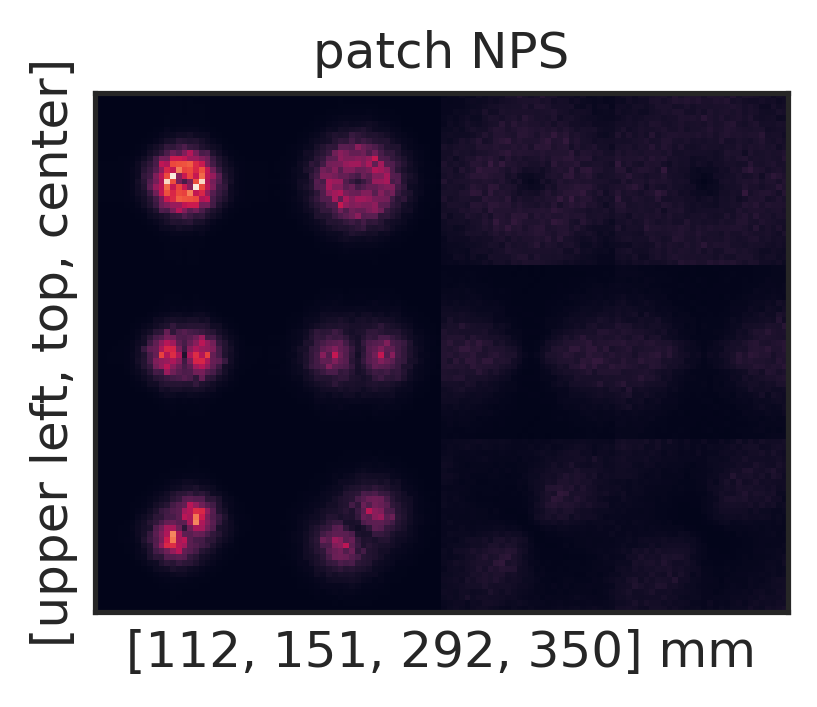

In [76]:
f, axs = plt.subplots(1,1, dpi=300, figsize=(3,2.25))
axs.imshow(np.concatenate([np.concatenate([compute_nps(p[c]) for p in corner_patches], axis=1) for c in corners]))
axs.set_title('patch NPS')
axs.set_xlabel(f'{diams} mm')
axs.set_ylabel(f'[upper left, top, center]')
axs.set_xticks([])
axs.set_yticks([])

In [77]:
normalize = lambda x: x/x.sum()
patch_nps = [normalize(compute_nps(noise_patch_dict[f'diameter{x}mm'])) for x in diams]

Text(0.5, 1.0, '[112, 151, 292, 350] mm averaged patch nps')

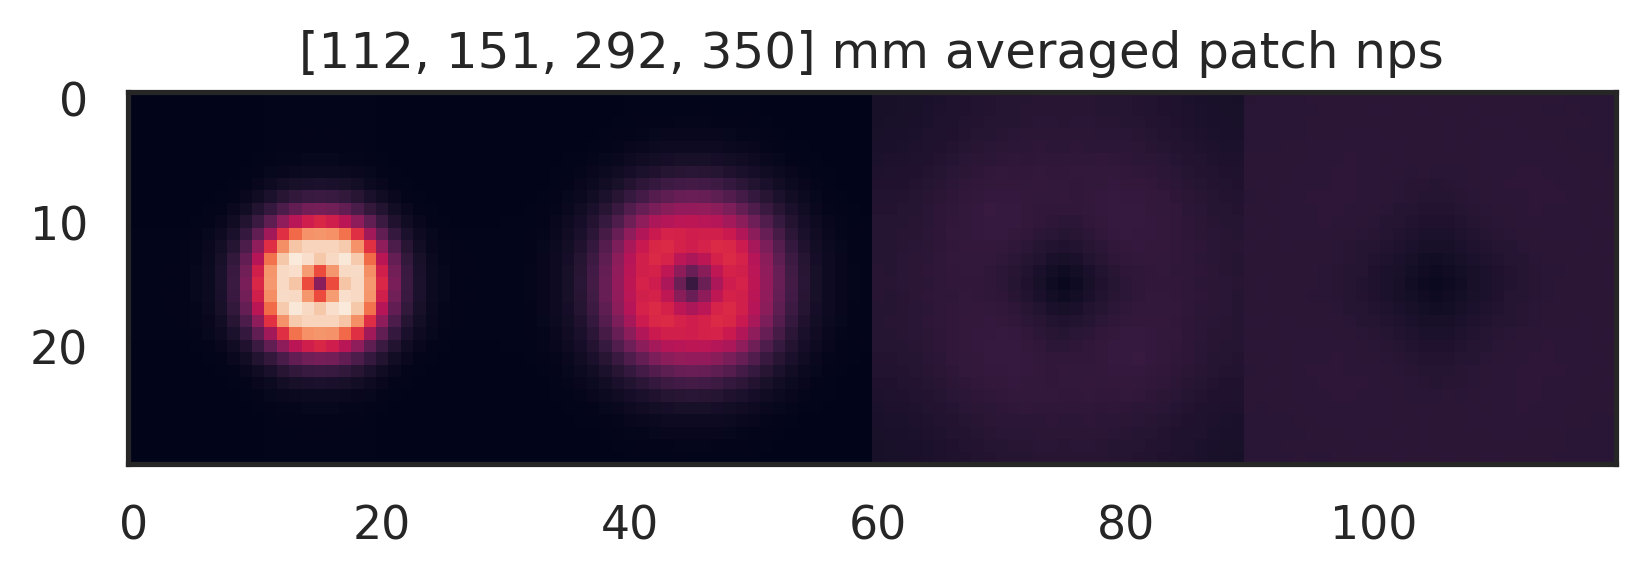

In [78]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate(patch_nps, axis=1))
plt.title(f'{diams} mm averaged patch nps')

 how do these generated noise patches compare to the training dataset noise patches?

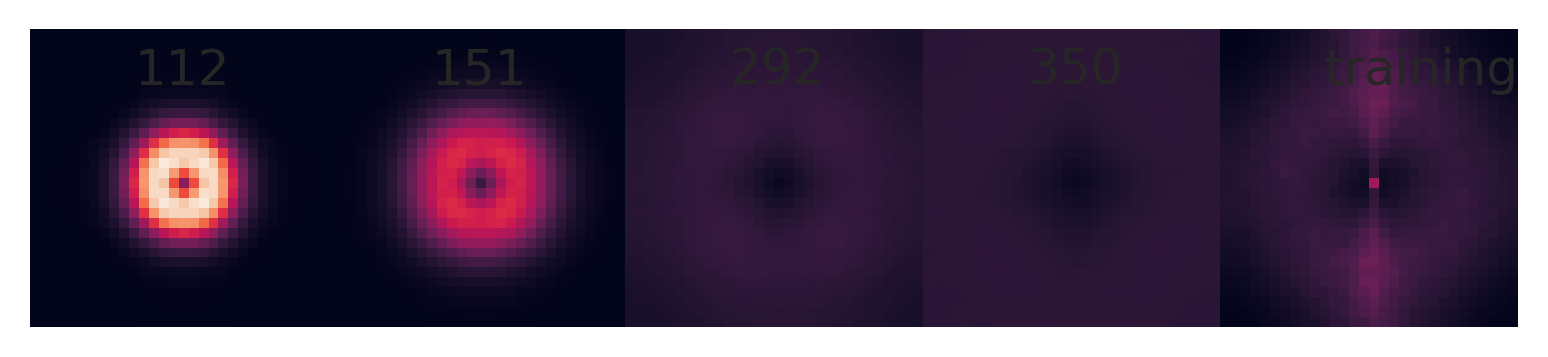

In [86]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate([*patch_nps, normalize(train_nps)], axis=1))
for idx, d in enumerate([*diams, 'training']):
    plt.annotate(f'{d}', (10 + idx*30, 5))
plt.axis('off')

Text(0.5, 1.0, 'Generated Noise NPS vs. Training Patch NPS')

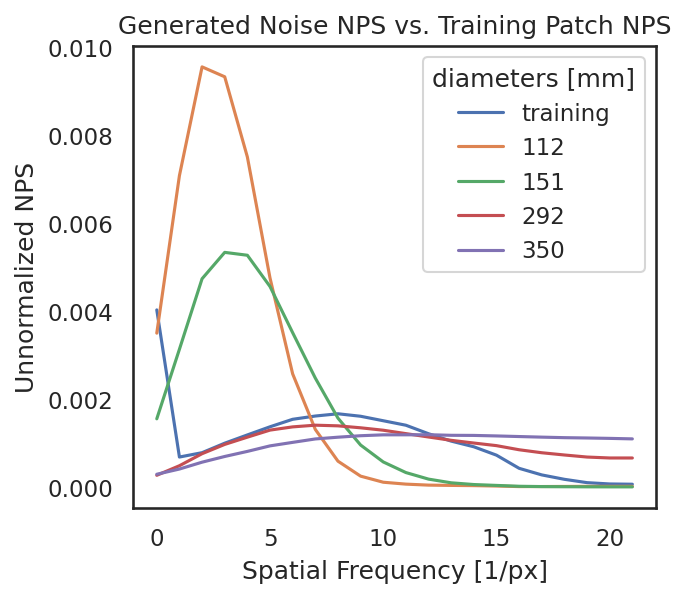

In [83]:
f, axs = plt.subplots(figsize=(4.5, 4), dpi=150)
for nps, diam in zip([normalize(train_nps), *patch_nps], ['training', *diams]):
    axs.plot(radial_profile(nps), label=diam)
plt.xlabel('Spatial Frequency [1/px]')
plt.ylabel('Unnormalized NPS')
plt.legend(title='diameters [mm]')
plt.title('Generated Noise NPS vs. Training Patch NPS')

 now save the noise patches